In [1]:
from config import project_config as config
from sleep_wake_filter import filter_sleep_series
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
def get_sleep_periods(df, sleep_col, time_col):
    local_df = df.copy()
    local_df['start'] = local_df[sleep_col].diff().fillna(1)  # The first row (Nan) is by nature an edge
    local_df['end'] = local_df[sleep_col].diff(-1).fillna(1)  # The last row (Nan) is by nature an edge
    local_df['start'] = (local_df['start'] == 1) & (local_df[sleep_col] == 1)  # Only intersted in start of sleep
    local_df['end'] = (local_df['end'] == 1) & (local_df[sleep_col] == 1)  # Only intersted in end of sleep

    start_times = local_df.loc[local_df['start'], time_col]
    end_times = local_df.loc[local_df['end'], time_col]

    return list(zip(start_times, end_times))


In [3]:
def read_sleep_dairies(path):
    sleep_diary_df = pd.DataFrame()
    for filename in [f for f in os.listdir(path) if f.endswith('csv')]:
        if filename.find('nap') >= 0:
            continue
        df = pd.read_csv(f'{path}/{filename}')
        sleep_diary_df = pd.concat([sleep_diary_df, df])

    # reading the extra nap diaries
    nap_df = pd.read_csv(f'{path}/SRCDRI001_Sleep Diary 019-036_nap.csv')
    nap_df = nap_df.rename(columns={
        'date_startnap': 'date_gotosleep',
        'date_endnap': 'date_finalawake',
        'nap_start': 'gotosleep',
        'nap_end': 'finalawake'   
    }).drop(columns=['nap times'])
    sleep_diary_df = pd.concat([sleep_diary_df, nap_df])
    sleep_diary_df = sleep_diary_df.sort_values(['participantNo', 'date_gotosleep']).reset_index(drop=True)

    sleep_diary_df['sleep_start'] = pd.to_datetime(sleep_diary_df['date_gotosleep'] + ' ' + sleep_diary_df['gotosleep'])
    sleep_diary_df['sleep_end'] = pd.to_datetime(sleep_diary_df['date_finalawake'] + ' ' + sleep_diary_df['finalawake'])
    sleep_diary_df = sleep_diary_df[['participantNo', 'sleep_start', 'sleep_end']]
    return sleep_diary_df


In [4]:
def make_plot_aligning_timestamp(df):
    local_df = df.copy()

    # Notes about why I replace dates with 1970-01-01 and 1970-01-02:
    # We need to slice the data by day and move each day to a separate column for plotting
    # This is done by creating a common time column (with same dummy date) so that same hours from different
    # days can be merged into the same row

    # Becuase of the following reasons, I replace actual dates with a dummy date before plotting:
    # 1) A time on its own is treated as an "O" (object) dtype by Pandas and that creates issues later when plotting
    # 2) Plus, we want multple subplots to share the x-axis which means they all (days) need to have the same time range
    #   so they cannot have different dtes.
    # 3) Another important issue is that each day here spans two different calendar days. So, if we drop the date
    # and sort by time only, we will get the wrong order, as 8 am on day 2 will be sorted above 8 pm on day 1

    # Instead of stripping the date and working with pure time, I attach a dummy date to all times when joining
    # different days below.
    # The tricky part is that hours before and after 12:00:00 need to have different (consecutive) dates
    # so they'll be sorted and plotted correctly
    before_noon = local_df['epoch_ts'].dt.hour.between(0, 11, inclusive='both')
    after_noon = local_df['epoch_ts'].dt.hour.between(12, 23, inclusive='both')
    # Remeber: a day starts at noon (12:00:00). So before noon hours are later (day=2 below) then after noon hours
    local_df.loc[before_noon, 'plot_aligning_timestamp'] = local_df['epoch_ts'].astype(str).apply(pd.Timestamp).apply(lambda x: x.replace(year=1970, month=1, day=2))
    local_df.loc[after_noon, 'plot_aligning_timestamp'] = local_df['epoch_ts'].astype(str).apply(pd.Timestamp).apply(lambda x: x.replace(year=1970, month=1, day=1))

    return local_df['plot_aligning_timestamp']

In [5]:
def plot_daily_sleep_indicators(df, data_cols, time_col, ax, labels, **kwargs):
    
    VERT_PAD = 0.25
    ONE_EPOCH = np.timedelta64(config['seconds_per_epoch'], 's')

    colors = matplotlib.colormaps['tab10']
    num_series = len(data_cols)
    for idx, col in enumerate(data_cols):
        sleep_periods = get_sleep_periods(df, col, time_col)
        plot_x_ranges = [(s, pd.Timedelta(e - s) + ONE_EPOCH) for s, e in sleep_periods]
        ax.broken_barh(plot_x_ranges, (idx, 1), color=colors(idx), label=labels[idx], **kwargs)

    ax.set_yticks([])
    ax.set_ylim((-VERT_PAD, num_series + VERT_PAD))
    ax.set_xlabel('Time')
    ax.set_ylabel('Series')
    
    return ax

In [6]:
def plot_sleep_predictions(df, fig, axes, sources, **kwargs):

    for day, ax in zip(pd.unique(df['day']), axes):
        day_fltr = df['day'] == day
        day_df = df[day_fltr]
        
        # This ensures that all epochs are present, whether or not we have data/predictions for them
        # print(day_df['pred'].isna().mean())
        all_epochs = pd.DataFrame({'plot_aligning_timestamp': pd.date_range('1970-01-01 12:00:00', '1970-01-02 11:59:30', freq='30s')})
        day_df = pd.merge(
            left=all_epochs,
            right=day_df,
            on='plot_aligning_timestamp',
            how='left'
        )
        
        plot_daily_sleep_indicators(
            day_df,
            data_cols=sources['df_columns'],
            time_col='plot_aligning_timestamp',
            ax=ax,
            labels=sources['plot_labels'],
            **kwargs
            )
        ax.set_ylabel(day_df['epoch_ts'].min().strftime("%b-%d"), fontsize=10)
            
    ONE_EPOCH = np.timedelta64(config['seconds_per_epoch'], 's')
    x_axis_min, x_axis_max = all_epochs['plot_aligning_timestamp'].min(), all_epochs['plot_aligning_timestamp'].max() + ONE_EPOCH
    axes[0].set_xlim(x_axis_min, x_axis_max)
    
    axes[0].spines['bottom'].set_linestyle('dotted')
    axes[0].spines['bottom'].set_color('green')
    axes[-1].spines['top'].set_linestyle('dotted')
    for ax in axes[1:-1]:
        ax.spines['bottom'].set_linestyle('dotted')
        ax.spines['top'].set_linestyle('dotted')
    
    axes[-1].set_xticks(pd.date_range(x_axis_min, x_axis_max, freq='2h'))
    axes[-1].set_xticklabels(pd.Series(pd.date_range(x_axis_min, x_axis_max, freq='2h')).dt.strftime(("%H:%M")))
    
    return fig, axes

In [7]:
sleep_diaries_path = 'data/Sleep diaries'
plot_path = 'Results/plots/v1'
os.makedirs(plot_path, exist_ok=True)

for id in config['subject_ids'][:3]:

    # This determines the order of the columns in the plot
    # And the names in the legend
    sources = {
        'df_columns': ['pred', 'AWS Sleep', 'Biobank Sleep'],
        'plot_labels': ['Pred', 'AWS', 'Bio']  # Legend
    }
    n_sources = len(sources['df_columns'])

    df = pd.read_csv(f'Results/combined/sub_{id:02d}.csv')
    df['epoch_ts'] = pd.to_datetime(df['epoch_ts'])
    df = df.sort_values('epoch_ts')

    # Reading in participation dates. This helps remove days with little data at the beginning and the end
    valid_days = pd.read_csv('data/participation_dates.csv')
    start_date = valid_days.loc[valid_days['subject_id'] == id, 'start_timestamp'].values[0]
    end_date = valid_days.loc[valid_days['subject_id'] == id, 'end_timestamp'].values[0]
    df = df[df['epoch_ts'].between(start_date, end_date, inclusive='left')]

    # # Each date show up in two rows of plots (before and after noon), but +1 because this doesn't apply two first and last dates
    n_days = len(pd.unique(df['epoch_ts'].dt.date)) - 1
    
    # Filter sleep predictions as described in this paper: https://www.pnas.org/doi/eplocal_df/10.1073/pnas.2116729119
    df['pred'] = filter_sleep_series(df['pred'])

    # Each day starts at noon (12:00:00). To group rows in such days, I use their time difference
    # with a dummy noon timestamp in distant past.
    df = df.assign(day=(df['epoch_ts'] - pd.to_datetime('1970-01-01 12:00:00')).dt.days)
    df['day'] = df['day'] - df['day'].min()  # And shift so the first day is 0

    df['plot_aligning_timestamp'] = make_plot_aligning_timestamp(df)
    
    fig, axes = plt.subplots(n_days, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(16, n_days * n_sources * 0.25))
    for plot_type in ['normal', 'na']:
        if plot_type == 'na':
            nan_df = df.copy()
            for col in sources['df_columns']:
                nan_df[col] = nan_df[col].map({1: 0, 0: 0, np.nan: 1})  # mask values and turn on nans
            
            plot_df = nan_df
        else:
            plot_df = df
        
        fig, axes = plot_sleep_predictions(df, fig, axes, sources, alpha=1 if plot_type=='normal' else 0.4)

    
    # plotting sleep diary episodes
    # These are in a different format and don't have epoch-by epoch value
    # instead we have sleep start and end times.
    # diary_df = read_sleep_dairies('data/Sleep diaries')

    

    # # # # # # # # # # # # # # # # # # # # # 

    axes[0].set_title(f'Subject {id}')
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=n_sources * 2)

    fig.savefig(f'{plot_path}/sub_{id:02d}.png', dpi=200)
    plt.close()
    

In [8]:
diary_df = read_sleep_dairies('data/Sleep diaries')

In [9]:
diary_df

,participantNo,sleep_start,sleep_end
0,1,2020-02-10 23:26:00,2020-02-11 06:00:00
1,1,2020-02-11 23:27:00,2020-02-12 07:03:00
2,1,2020-02-12 23:10:00,2020-02-13 07:30:00
3,1,2020-02-04 00:00:00,2020-02-04 07:00:00
4,1,2020-02-04 23:35:00,2020-02-05 05:30:00
...,...,...,...
477,36,2021-11-05 23:33:00,2021-11-06 06:55:00
478,36,2021-11-07 00:20:00,2021-11-07 06:45:00
479,36,2021-11-08 00:12:00,2021-11-08 08:15:00
480,36,2021-11-09 00:02:00,2021-11-09 04:53:00


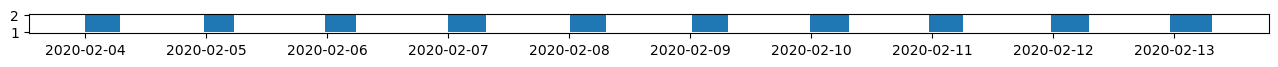

In [10]:
# sleep_periods = get_sleep_periods(df, col, time_col)
id = 32
start_time = diary_df.loc[diary_df['participantNo'] == 1, 'sleep_start']
end_time = diary_df.loc[diary_df['participantNo'] == 1, 'sleep_end']
sleep_periods = list(zip(start_time, end_time))
plot_x_ranges = [(s, pd.Timedelta(e - s)) for s, e in sleep_periods]

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 1 * 1 * 0.25))
ax.broken_barh(plot_x_ranges, (1, 1))